### Fetch data

#### Load dependencies

In [32]:
# path variables
import sys
sys.path.insert(0, '/Users/sarfrazahmed/Documents/projects/deposit-model/conf')
from config import SQLQuery

# core libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# plotting libraries
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from pandas_profiling import ProfileReport

# setting constants
pio.templates.default = 'plotly_dark'
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
color_map = {'high': '#ef553b', 'low': '#636efa'}

### Fetching Data

In [2]:
querySno = SQLQuery('snowflake')
q = querySno

df_raw = q("""with 

TRANSACTIONS AS -- get all credit transactions
(
    select BUSINESS_ID,
           TRANSACTION_DATE,
           AMOUNT 
  from "PROD_DB"."DATA"."TRANSACTIONS" 
  where type='credit' and status='active'
  group by 1,2,3
),

BUSINESS_DETAIL as -- get all business accounts created between Jan 2021 and Feb 2022
(
  select *
  from "PROD_DB"."DATA"."BUSINESSES"
  where ACCOUNT_CREATE_DATE between '2021-01-01' and '2022-02-28'
),

ALLOY_PERSONS as -- get all the alloy persons data (max of application_versions_id in case of duplicates)
(
  select * from (
select * ,
       row_number() over (partition by APPLICATION_ID order by APPLICATION_VERSION_ID desc) as rank
from "PROD_DB"."DATA"."ALLOY_EVALUATIONS_PERSONS") 
where rank=1
),

APPLICATION_DETAIL as -- get all entries from applications table
(
  select *
  from "PROD_DB"."DATA"."APPLICATIONS"
),

BASE AS -- create base table with business and transactions
(
    select b.BUSINESS_ID,b.APPLICATION_ID,sum(t.amount) as total_credit_amount
    from BUSINESS_DETAIL b 
    inner join TRANSACTIONS t
    on b.BUSINESS_ID=t.BUSINESS_ID
    where DATEDIFF(day, ACCOUNT_CREATE_DATE, TRANSACTION_DATE) between 0 AND 60
    group by 1,2
)

    select * 
    from base
    left join APPLICATION_DETAIL B
    on base.APPLICATION_ID = B.APPLICATION_ID""")

df_raw.shape

(110642, 101)

#### Add target variable

In [3]:
df = df_raw.copy(deep=True)
df['deposit_class'] = np.where(df['total_credit_amount']<800, 'low', np.where(df['total_credit_amount']>1200, 'high', 'mid'))
df = df[df['deposit_class'] != 'mid']
print(df['deposit_class'].value_counts())
df.shape

low     53190
high    49719
Name: deposit_class, dtype: int64


(102909, 102)

#### Deposit Class Distribution

In [4]:
fig = px.histogram(df, 
                   x="deposit_class", 
                   color="deposit_class", 
                   text_auto=True, 
                   color_discrete_map=color_map)
fig.show()

#### Derived variables

In [5]:
# Application Completion Duration
df['application_completion_duration'] = (df['application_complete_datetime'] - df['application_start_datetime']).astype('timedelta64[m]')

# Email Domain
df['email_domain_variable'] = np.where(df['email_domain'].isin(['gmail.com', 'yahoo.com', 'outlook.com', 'icloud.com', 'hotmail.com']), df['email_domain'], 'others')

# Week Number
df['week'] = df['application_start_datetime'].dt.week

# Business Age
df['date_of_establishment_dt'] = pd.to_datetime(df['date_of_establishment'], format='%Y-%m', errors='coerce').dropna()
df['business_age'] = round((df['application_start_datetime'] - df['date_of_establishment_dt']) / np.timedelta64(1, 'Y'),2)
df['business_age'] = df['business_age'].fillna(0)

# Number of Employees
df["number_of_employees"] = pd.to_numeric(df["number_of_employees"])
df['number_of_employees_bin'] = df["number_of_employees"]
df['number_of_employees_bin'] = np.where((df['number_of_employees']>=5) & (df['number_of_employees']<=10), '5-10', 
                                np.where((df['number_of_employees']>10) & (df['number_of_employees']<=20), '11-20', 
                                np.where((df['number_of_employees']>20), '20+', df['number_of_employees_bin'])))

# Website Flag
df['website_flag'] = np.where(df['website'] != df['website'], 'Offline', 'Online')

/var/folders/gb/3vclgrsn0c93f13mbb7wggxc0000gn/T/ipykernel_8957/1308360415.py:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



#### List dependent and independent

In [47]:
dependent_variable = ['deposit_class']
independent_variables = ['business_type',
                         'business_address_state',
                         'email_domain_variable',
                         'application_completion_duration',
                        #  'week',
                         'application_channel',
                         'estimated_monthly_revenue', 
                         'incoming_ach_payments',
                         'check_deposit_amount',
                         'incoming_wire_transfer',
                         'outgoing_ach_and_checks',
                         'outgoing_wire_transfers',
                         'business_age',
                         'industry_category_name',
                         'number_of_employees_bin',
                         'website_flag',
                         'high_risk_industry',
                         'aml_risk_score']

                         # device data

#### Drop null rows

In [48]:
print(df.shape)
df.dropna(subset=independent_variables, inplace=True)
print(df.shape)

(102844, 109)
(102844, 109)


#### Encode categorical variables

In [49]:
for variable in list(df[independent_variables].select_dtypes(include=['object']).columns):
    df[variable]=df[variable].astype('category').cat.codes
df[independent_variables].head()

,business_type,business_address_state,email_domain_variable,application_completion_duration,application_channel,estimated_monthly_revenue,incoming_ach_payments,check_deposit_amount,incoming_wire_transfer,outgoing_ach_and_checks,outgoing_wire_transfers,business_age,industry_category_name,number_of_employees_bin,website_flag,high_risk_industry,aml_risk_score
1,1,4,3,12.0,8,2,2,0,0,2,0,3.87,8,0,1,0,164.0
2,3,45,0,10.0,4,0,0,0,0,0,0,0.00,1,0,0,0,185.0
3,3,17,0,20.0,12,5,5,5,0,0,0,0.00,16,0,0,0,185.0
4,1,9,3,26.0,0,4,4,4,2,2,2,0.17,7,0,1,0,193.0
5,1,4,3,3898.0,12,2,0,0,0,0,0,0.03,19,0,1,0,145.0


#### Train test split

In [50]:
X = df[independent_variables]
y = df[dependent_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(71990, 17)
(30854, 17)
(71990, 1)
(30854, 1)


#### Model Fit

In [97]:
clf = tree.DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train.values, y_train.values)

DecisionTreeClassifier(max_depth=4, random_state=42)

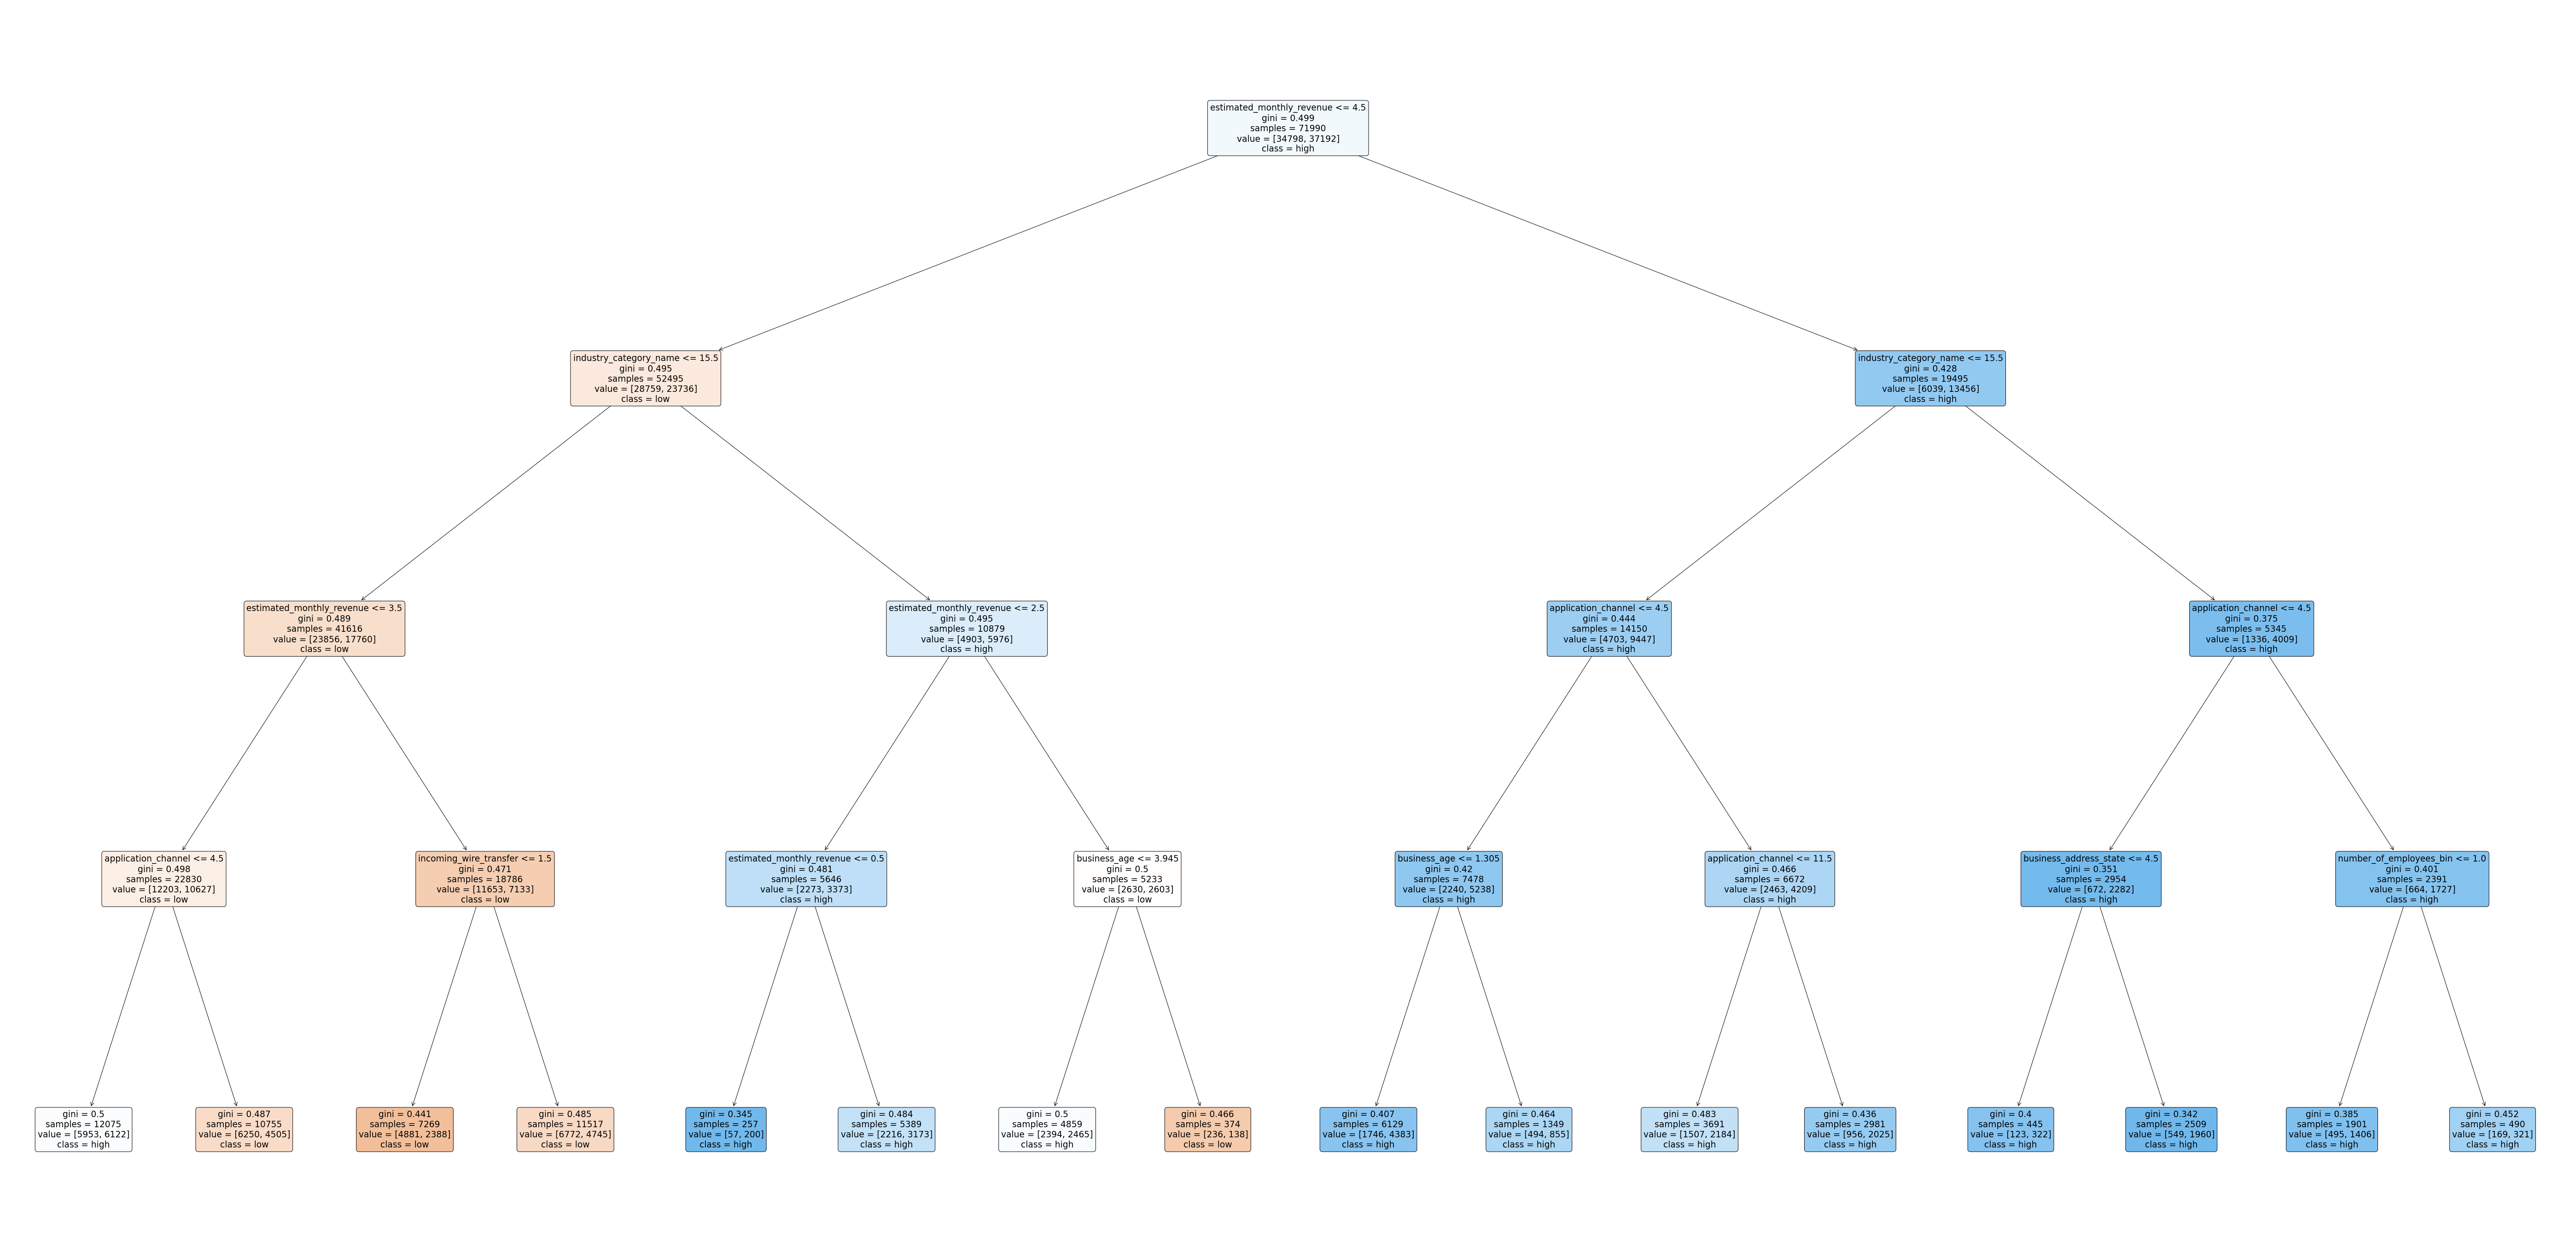

In [98]:
plt.figure(figsize=(100,50))
tree.plot_tree(clf,
               feature_names = X_train.columns, 
               class_names=y_train['deposit_class'].unique(),
               rounded=True,
               filled = True)
plt.show()

#### Train Report

In [99]:
y_pred = clf.predict(X_train.values)

# Confusion Matrix
cmtx = pd.DataFrame(
    confusion_matrix(y_train, y_pred, labels=['high', 'low']), 
    index=['true:high', 'true:low'], 
    columns=['pred:high', 'pred:low']
)
print(cmtx, '\n')

# Accuracy Score
print('Accuracy Score:', accuracy_score(y_train, y_pred), '\n')

# Classification Report
print(classification_report(y_train, y_pred))

           pred:high  pred:low
true:high      18139     16659
true:low       11776     25416 

Accuracy Score: 0.6050145853590776 

              precision    recall  f1-score   support

        high       0.61      0.52      0.56     34798
         low       0.60      0.68      0.64     37192

    accuracy                           0.61     71990
   macro avg       0.61      0.60      0.60     71990
weighted avg       0.61      0.61      0.60     71990



#### Test Scores

In [100]:
y_pred = clf.predict(X_test.values)

# Confusion Matrix
cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=['high', 'low']), 
    index=['true:high', 'true:low'], 
    columns=['pred:high', 'pred:low']
)
print(cmtx, '\n')

# Accuracy Score
print('Accuracy Score:', accuracy_score(y_test, y_pred), '\n')

# Classification Report
print(classification_report(y_test, y_pred))

           pred:high  pred:low
true:high       7727      7158
true:low        5074     10895 

Accuracy Score: 0.6035522136513904 

              precision    recall  f1-score   support

        high       0.60      0.52      0.56     14885
         low       0.60      0.68      0.64     15969

    accuracy                           0.60     30854
   macro avg       0.60      0.60      0.60     30854
weighted avg       0.60      0.60      0.60     30854



In [79]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)
# Train
model.fit(X_train, y_train)
# Extract single tree
estimator = model.estimators_[5]

/var/folders/gb/3vclgrsn0c93f13mbb7wggxc0000gn/T/ipykernel_8957/196944601.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

